# Chemical Equilibrium Retrievals



This tutorial covers how to run thermochemical equilibrium retrievals with POSEIDON. We recommend you first go through the [\"Chemical Equilibrium Transmission Spectra\"](transmission_equilibrium.html) tutorial (for background on the assumption of chemical equilibrium) and the [\"Atmospheric Retrievals with POSEIDON\"](retrieval_basic.html) tutorial (for an introduction to retrievals).

<div class="alert alert-warning">

  **Warning:**

  Chemical equilibrium is a *strong* assumption. Before proceeding with real data, it is worth checking whether the planet you are modelling is theoretically expected the be in equilibrium over the pressure range probed by your observations. Even if the planet is probably in equilibrium (e.g. an ultra-hot Jupiter), we always recommend running a free retrieval for comparison.

</div>

With that caveat out of the way, let's begin the thrilling saga of equilibrium retrievals. 

### Case Study: A JWST Hot Jupiter Transmission Spectrum

The day has finally arrived. You hold in your hands the first complete near-infrared transmission spectrum of the hot Jupiter WASP-62b.

You chose WASP-62b because there is evidence from the Hubble and Spitzer space telescopes that it has a clear atmosphere ([Alam et al., 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...906L..10A/abstract)). And now the incredible observing capabilities of JWST will reveal WASP-62b's atmosphere like never before.

First, you specify the system properties.

In [1]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J

#***** Define stellar properties *****#

R_s = 1.23*R_Sun     # Stellar radius (m)
T_s = 6230.0         # Stellar effective temperature (K)
Met_s = 0.04         # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.45       # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'WASP-62b'  # Planet name used for plots, output files etc.

R_p = 1.32*R_J     # Planetary radius (m)
g_p = 7.3978       # Gravitational field of planet (m/s^2)
T_eq = 1394        # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

Your JWST observations come from two different instrument modes: NIRISS SOSS (0.6-2.8 μm) and NIRSpec G395H (2.8-5.2 μm). You observed one transit with each mode to obtain a wide wavelength range that covers the absorption features of the major oxygen-bearing and carbon-bearing molecules expected in hot Jupiter atmospheres ($\rm{H}_2 \rm{O}$, $\rm{CO}$, $\rm{CO}_2$, and $\rm{CH}_4$).  

The data has been split into four files:

* NIRISS SOSS Order 2.
* NIRISS SOSS Order 1.
* NIRSpec G395H Detector NRS1.
* NIRSpec G395H Detector NRS2.

You load the data to finally gaze upon WASP-62b's transmission spectrum.

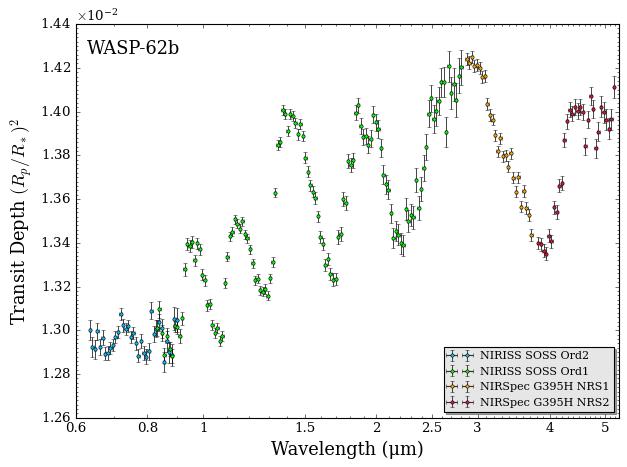

In [2]:
from POSEIDON.core import load_data, wl_grid_constant_R
from POSEIDON.visuals import plot_data

#***** Wavelength grid *****#
 
wl_min = 0.6     # Minimum wavelength (um)
wl_max = 5.3     # Maximum wavelength (um)
R = 10000        # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Specify data location and instruments  *****#

data_dir = '../../../POSEIDON/reference_data/observations/WASP-62b'

instruments = ['JWST_NIRISS_SOSS_Ord2', 'JWST_NIRISS_SOSS_Ord1',        # NIRISS SOSS Order 2 and Order 1
               'JWST_NIRSpec_G395H_NRS1', 'JWST_NIRSpec_G395H_NRS2']    # NIRSpec G395H detectors NRS1 and NRS2

datasets = [planet_name + '_Eq_Chem_NIRISS_SOSS_Ord2.dat',    
            planet_name + '_Eq_Chem_NIRISS_SOSS_Ord1.dat',
            planet_name + '_Eq_Chem_NIRSpec_G395H_NRS1.dat',
            planet_name + '_Eq_Chem_NIRSpec_G395H_NRS2.dat'] 

# Load dataset, pre-load instrument PSF and transmission function
data = load_data(data_dir, datasets, instruments, wl)

# Plot our data
fig_data = plot_data(data, planet_name, 
                     data_colour_list = ['deepskyblue', 'lime', 'orange', 'crimson'],
                     data_labels = ['NIRISS SOSS Ord2', 'NIRISS SOSS Ord1',
                                    'NIRSpec G395H NRS1', 'NIRSpec G395H NRS2'],
                     data_marker_list = ['o', 'o', 'o', 'o'],
                     legend_location = 'lower right')

Wow, what an incredible spectrum! JWST is truly a wonder.

<div class="alert alert-info">

  **Note:**

  This dataset is simulated JWST data. Any similarity to real exoplanet spectra is entirely coincidental.
  
  If anyone ever actually observes WASP-62b with JWST, this tutorial will be updated (and you'll have my eternal gratitude, since WASP-62b is fantastic science target). You might want to examine the next retrieval tutorial ([\"Supporting a JWST Proposal with POSEIDON\"](JWST_proposal.html)) if you feel inspired to try observing this planet ;) 

</div>

### Create an Equilibrium Retrieval Model

For initial exploration, you decide to try an equilibrium chemistry retrieval. This should give you a first estimate of the metallicity and $\rm{C/O}$ ratio of WASP-62b's atmosphere, which can be useful quantities to understand the formation and migration history of the planet.

<div class="alert alert-info">

  **Tip:**

  The retrieval below is a *subset* equilibrium chemistry retrieval in which only $\rm{H}_2 \rm{O}$, $\rm{CO}$, $\rm{CO}_2$, and $\rm{CH}_4$ are included for demonstration purposes and computational speed. You can include all the chemical species in the equilibrium grid by setting ``param_species = ['all']``.
  
  See the [\"Chemical Equilibrium Transmission Spectra\"](transmission_equilibrium.html) tutorial for more details on the difference between *subset* and *full* equilibrium models.
  
</div>

In [3]:
from POSEIDON.core import define_model
import numpy as np

#***** Define model *****#

model_name = 'eq_chemistry'

bulk_species = ['H2', 'He']                    # H2 + He comprises the bulk atmosphere
param_species = ['H2O', 'CH4', 'CO', 'CO2']    # Equilibrium model with *only* H2O, CH4, CO, and CO2

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'isotherm', X_profile = 'chem_eq',    # 'X_profile' is the key to create an equilibrium model
                     cloud_model = 'cloud-free')


One of the nice aspects of equilibrium retrievals is the atmospheric composition is only described by two free parameters: the metallicity and carbon-to-oxygen ratio. This low number of free parameters makes equilibrium retrievals relatively fast.

In [4]:
print("Free parameters : " + str(model['param_names']))

Free parameters : ['R_p_ref' 'T' 'C_to_O' 'log_Met']


### Setting Up Priors

In [5]:
from POSEIDON.core import set_priors

#***** Set priors for retrieval *****#

# Initialise prior type dictionary
prior_types = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types['T'] = 'uniform'
prior_types['R_p_ref'] = 'uniform'
prior_types['C_to_O'] = 'uniform'
prior_types['log_Met'] = 'uniform'

# Initialise prior range dictionary
prior_ranges = {}

# Specify prior ranges for each free parameter
prior_ranges['T'] = [400, 1600]
prior_ranges['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges['C_to_O'] = [0.2, 1.2]             # Full grid runs from 0.2 to 2
prior_ranges['log_Met'] = [-1,3]                # Full grid runs from -1 to 4

# Create prior object for retrieval
priors = set_priors(planet, star, model, data, prior_types, prior_ranges)

### Pre-Load Opacities

In [6]:
from POSEIDON.core import read_opacities

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 400     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 1600    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
H2O done
CH4 done
CO done
CO2 done
Opacity pre-interpolation complete.


### Run Retrieval 

Finally, you are ready to retrieve WASP-62b's JWST transmission spectrum.

This POSEIDON retrieval should take about an hour on 1 core for a typical laptop.

<div class="alert alert-info">

  **Tip:**

  Retrievals run faster on multiple cores. When running the cells in this Jupyter notebook, only a single core will be used. You can run a multi-core retrieval on 4 cores by converting this Jupyter notebook into a python script, then calling mpirun on the .py file:

  ```
  mpirun -n 4 python -u YOUR_RETRIEVAL_SCRIPT.py
  ```
  
</div>

In [7]:
from POSEIDON.retrieval import run_retrieval

#***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 10.0   # Retrieved R_p_ref parameter will be the radius at 10 bar

#***** Run atmospheric retrieval *****#

run_retrieval(planet, star, model, opac, data, priors, wl, P, P_ref, R = R, 
              spectrum_type = 'transmission', chem_grid = 'fastchem',       # Important! This specifies the equilibrium chemistry grid to load
              sampling_algorithm = 'MultiNest', 
              N_live = 400, verbose = True)

Reading in database for equilibrium chemistry model...
POSEIDON now running 'eq_chemistry'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.991189
Replacements:                                450
Total Samples:                               454
Nested Sampling ln(Z):            **************
Acceptance Rate:                        0.967118
Replacements:                                500
Total Samples:                               517
Nested Sampling ln(Z):            **************
Acceptance Rate:                        0.945017
Replacements:                                550
Total Samples:                               582
Nested Sampling ln(Z):            -947032.054286
A

### Plot Retrieval Results

Generating corner plot ...


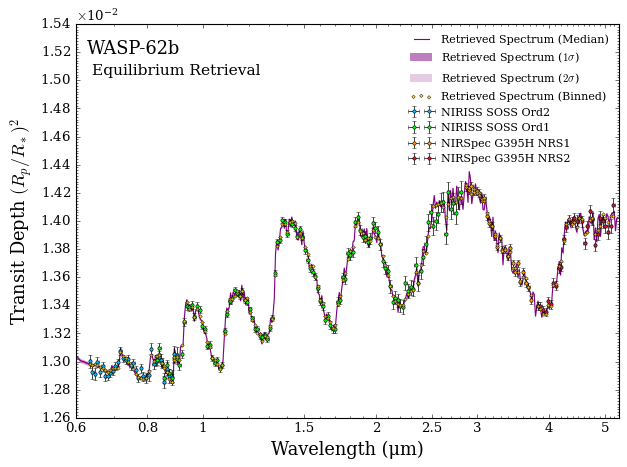

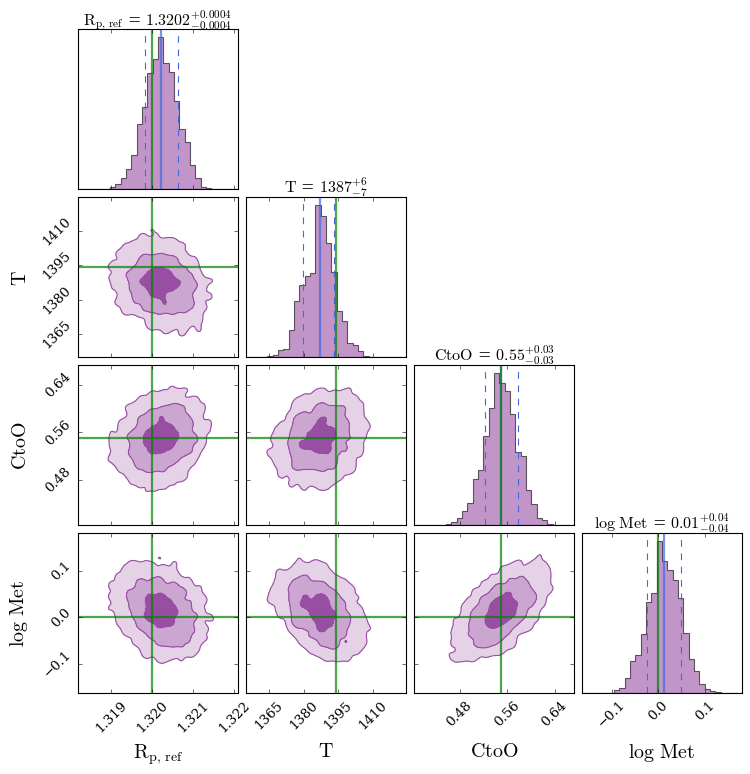

In [13]:
from POSEIDON.utility import read_retrieved_spectrum, plot_collection
from POSEIDON.visuals import plot_spectra_retrieved
from POSEIDON.corner import generate_cornerplot

#***** Plot retrieved transmission spectrum *****#

# Read retrieved spectrum confidence regions
wl, spec_low2, spec_low1, spec_median, \
spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name)

# Create composite spectra objects for plotting
spectra_median = plot_collection(spec_median, wl, collection = [])
spectra_low1 = plot_collection(spec_low1, wl, collection = []) 
spectra_low2 = plot_collection(spec_low2, wl, collection = []) 
spectra_high1 = plot_collection(spec_high1, wl, collection = []) 
spectra_high2 = plot_collection(spec_high2, wl, collection = [])

# Produce figure
fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1, 
                                  spectra_high1, spectra_high2, planet_name,
                                  data, R_to_bin = 200,
                                  data_colour_list = ['deepskyblue', 'lime', 'orange', 'crimson'],
                                  data_labels = ['NIRISS SOSS Ord2', 'NIRISS SOSS Ord1',
                                                 'NIRSpec G395H NRS1', 'NIRSpec G395H NRS2'],
                                  data_marker_list = ['o', 'o', 'o', 'o'],
                                  legend_location = 'upper right',
                                  legend_box = False,
                                  y_min = 1.26e-2, y_max = 1.54e-2,
                                  plt_label = 'Equilibrium Retrieval')

#***** Make corner plot *****

fig_corner = generate_cornerplot(planet, model,
                                 true_vals = [R_p/R_J, T_eq, 0.55, 0.0])   # Overplot the true values used to make the synthetic data

And there you have it, precise constraints on the $\rm{C/O}$ ratio and metallicity of WASP-62b's atmosphere.